In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

np.random.seed(42)  # 결과의 일관성을 위한 시드 설정

In [30]:
risk_free_rate = 0.03  #예시 무위험 수익률

# 주식 심볼 리스트
symbols = ['AAPL', 'MSFT', 'GOOGL', "AMZN"]
N = len(symbols)

# 데이터 다운로드 (최근 1년치 일간 데이터)
data = yf.download(symbols, start="2004-01-01", end="2024-01-01")['Adj Close']

[*********************100%%**********************]  4 of 4 completed


In [33]:
# 일간 수익률 계산
returns = data.pct_change().dropna()

# 일간 수익률의 공분산
cov_matrix = returns.cov()

# 연간 공분산으로 변환 (252 거래일 기준)
annual_cov_matrix = cov_matrix * 252 * 10 # 10 years

# Efficient Frontier
Just do a lot of trial and pick the best
- Red star: optimal risky portfolio
- Green star: minimum variance portfolio

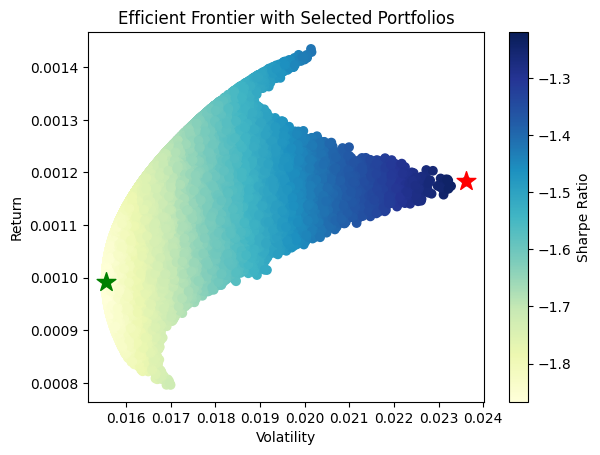

In [61]:
# Number of portfolios to simulate
num_portfolios = 50000

mean_returns = returns.mean()
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(N)
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(mean_returns * weights)
    
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    
    # Store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = sharpe_ratio

# Convert results array to DataFrame
results_frame = pd.DataFrame(results.T, columns=['ret', 'stdev', 'sharpe'])

# Find the portfolio with the highest Sharpe ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

# Find the portfolio with the minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

# Create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='YlGnBu')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_port.iloc[1], max_sharpe_port.iloc[0], color='r', marker='*', s=200) # red star
plt.scatter(min_vol_port.iloc[1], min_vol_port.iloc[0], color='g', marker='*', s=200) # green star
plt.title('Efficient Frontier with Selected Portfolios')
plt.show()

# Global Mnimum Varaicne Portfolio
Using minimize() function, Do not need to try many times.

In [43]:
# 최적화할 목적 함수: 포트폴리오 분산
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# 초기 가중치 설정
initial_weights = np.array([1/N] * N)

# 가중치 제약 조건 (모든 가중치 합이 1)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# 가중치 범위 (0에서 1 사이)
bounds = tuple((0, 1) for _ in range(N))

# 최적화 실행
opt_result = minimize(
    portfolio_variance, 
    initial_weights, 
    args=(annual_cov_matrix,), 
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints
)

# 최적 가중치
optimal_weights = opt_result.x
gmv_expected_return = np.sum(returns.mean() * optimal_weights * 252 * 10)
gmv_variance = opt_result.fun

Optimal Weights for GMVP:
AAPL: 0.2003
MSFT: 0.0468
GOOGL: 0.2566
AMZN: 0.4963


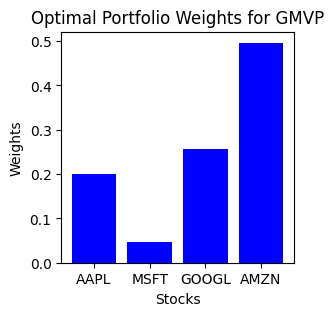

In [44]:
print("Optimal Weights for GMVP:")
for symbol, weight in zip(symbols, optimal_weights):
    print(f"{symbol}: {weight:.4f}")

# 가중치 분포 그래프
plt.figure(figsize=(3, 3))
plt.bar(symbols, optimal_weights, color='blue')
plt.title('Optimal Portfolio Weights for GMVP')
plt.xlabel('Stocks')
plt.ylabel('Weights')
plt.show()

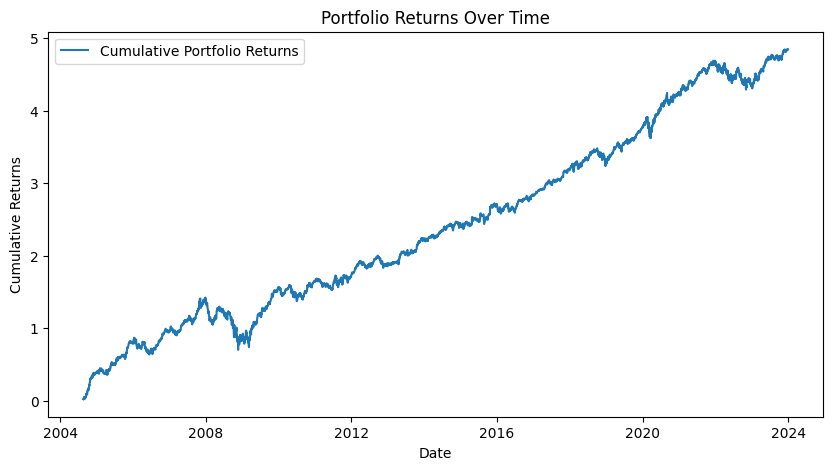

In [45]:
# 포트폴리오의 일간 수익률 계산
portfolio_returns = returns.dot(optimal_weights)

# 수익률 시계열 그래프
plt.figure(figsize=(10, 5))
plt.plot(portfolio_returns.cumsum(), label='Cumulative Portfolio Returns')
plt.title('Portfolio Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Tangent Portfolio
Maximize Sharpe Ratio == Minimize Negative Sharpe Ratio

In [46]:
def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    port_return = np.dot(weights, expected_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return - (port_return - risk_free_rate) / port_volatility  

def find_tangent_portfolio(returns, risk_free_rate):
    num_assets = returns.shape[1]
    expected_returns = np.mean(returns, axis=0)
    cov_matrix = np.cov(returns.T)
    args = (expected_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights = 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets,]
    result = minimize(
        negative_sharpe_ratio, 
        initial_guess, 
        args=args, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints)
    return result, expected_returns, cov_matrix

def print_tangent_portfolio(result, expected_returns, cov_matrix, risk_free_rate):
    if result.success:
        weights = result.x
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        print("Optimal Weights for Tangent Portfolio:")
        print("\nExpected Portfolio Return:", portfolio_return)
        print("Expected Portfolio Volatility:", portfolio_volatility)
        print("Maximum Sharpe Ratio:", sharpe_ratio)
    else:
        print("Optimization failed:", result.message)


Optimal Weights for Tangent Portfolio:
[5.55111512e-17 1.00000000e+00 3.05311332e-16 1.49880108e-15]

Expected Portfolio Return: 0.0011853487713112533
Expected Portfolio Volatility: 0.02418417570513749
Maximum Sharpe Ratio: -1.1914671634877179


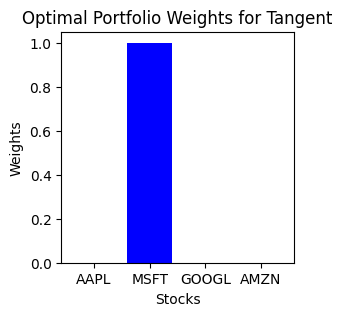

In [52]:
# 탄젠트 포트폴리오 최적화 
result, tangent_expected_returns, cov_matrix = find_tangent_portfolio(returns, risk_free_rate)
tangent_weights = result.x
tangent_variance = result.fun

# 결과 출력
print_tangent_portfolio(result, tangent_expected_returns, cov_matrix, risk_free_rate)

# 가중치 분포 그래프
plt.figure(figsize=(3, 3))
plt.bar(symbols, tangent_weights, color='blue')
plt.title('Optimal Portfolio Weights for Tangent')
plt.xlabel('Stocks')
plt.ylabel('Weights')
plt.show()


Plot

Ticker
AAPL     0.001450
AMZN     0.001185
GOOGL    0.001011
MSFT     0.000783
dtype: float64

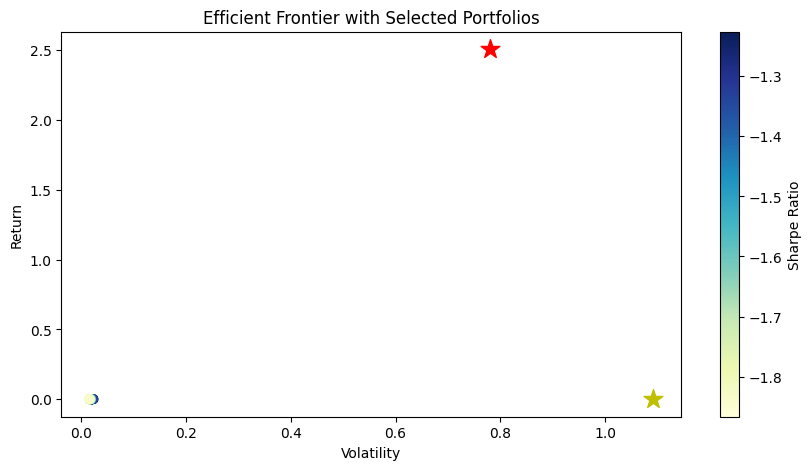

In [60]:
# Create scatter plot coloured by Sharpe Ratio
tangent_expected_returns = tangent_expected_returns.mean()
plt.figure(figsize=(10, 5))
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='YlGnBu')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(gmv_variance**0.5, gmv_expected_return, color='r', marker='*', s=200) # red star
plt.scatter(tangent_variance**0.5, tangent_expected_returns, color='y', marker='*', s=200) # green star
plt.title('Efficient Frontier with Selected Portfolios')
plt.show()